In [59]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [75]:
df=pd.read_csv("/content/mexican_movies.csv")

In [76]:
df.head()

,Unnamed: 0,adult,backdrop_path,genre_ids,id,original_language,original_title,overview,popularity,poster_path,...,vote_average,vote_count,runtime,budget,revenue,director,cast_1,cast_2,cast_3,genre_names
0,0,False,/8FmvRL0XPAdCFRs4w2wcYBwuKUO.jpg,[35],1233620,es,"¡Qué Huevos, Sofía!",Sofia gives everything for the company where s...,101.2558,/hhfWpdNmPwU1VV7zhNA1nOMbHkH.jpg,...,8.750,12,106,0,0,Carlos Santos,Giovanna Romo,Sergio Mayer,Liliana Arriaga,['Comedy']
1,1,False,/deUWVEgNh2IGjShyymZhaYP40ye.jpg,"[28, 12, 53]",1356039,es,Contraataque,When a hostage rescue mission creates a new en...,38.2484,/38I76hGcFY6xB47pjm7pZwkfuAF.jpg,...,8.343,683,85,0,0,Chava Cartas,Luis Alberti,Noé Hernández,Leonardo Alonso,"['Action', 'Adventure', 'Thriller']"
2,2,False,/iznPd7PLnCBA1G50M4DuA9wvCIy.jpg,[35],1307520,es,La más fan,"Canceled in Hollywood, star Lana Cruz heads to...",25.6554,/wgUmsekYPOt9ZQ8ero91qRnmhQY.jpg,...,5.850,30,91,0,0,María Torres,Kate del Castillo,Diana Bovio,Daniel Raymont,['Comedy']
3,3,False,/o5vasl0xbZWWKQnAlaBTSgntHH2.jpg,[27],1208808,es,Turno nocturno,A young nurse with a domestic abuse past start...,23.7613,/iSSx9Bys64vlOkvkyKXtp19P7Re.jpg,...,6.284,148,107,0,0,Rigoberto Castañeda,Paulina Gaitán,Tony Dalton,Patricia Reyes Spíndola,['Horror']
4,4,False,/8U1xsLUtWSN8WlH0xzwYGZxHMUi.jpg,[35],1304594,es,Una Pequeña Confusión,"Lola and Cuau, a progressive middle-class pair...",16.4031,/ApXr9phfcvIX06tLGhxOH2kmndb.jpg,...,7.380,71,107,0,0,Ariel Winograd,Ana de la Reguera,Juanpa Zurita,Vico Escorcia,['Comedy']


In [77]:
# Eliminar filas con valores faltantes críticos
df = df.dropna(subset=["runtime", "budget", "revenue", "vote_average"])

# Crear variable binaria de éxito
df["exito"] = df["vote_average"].apply(lambda x: 1 if x >= 7 else 0)

# Extraer año y mes de la fecha de estreno
df["release_date"] = pd.to_datetime(df["release_date"], errors="coerce")
df["release_year"] = df["release_date"].dt.year
df["release_month"] = df["release_date"].dt.month

In [78]:
# Conversión de valores string a lista
df['genre_names'] = df['genre_names'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)


In [79]:
# Obtener todos los géneros únicos
all_genres = set()
df['genre_names'].apply(lambda x: all_genres.update(x)).tolist()

# Crear variables binarias con nombres como genre_Comedy, genre_Action, etc.
for genre in sorted(all_genres):
    col_name = f"genre_{genre.replace(' ', '_')}"  # Por si el nombre tiene espacios
    df[col_name] = df['genre_names'].apply(lambda x: int(genre in x))


In [80]:
df.columns

Index(['Unnamed: 0', 'adult', 'backdrop_path', 'genre_ids', 'id',
       'original_language', 'original_title', 'overview', 'popularity',
       'poster_path', 'release_date', 'title', 'video', 'vote_average',
       'vote_count', 'runtime', 'budget', 'revenue', 'director', 'cast_1',
       'cast_2', 'cast_3', 'genre_names', 'exito', 'release_year',
       'release_month', 'genre_Action', 'genre_Adventure', 'genre_Animation',
       'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama',
       'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror',
       'genre_Music', 'genre_Mystery', 'genre_Romance',
       'genre_Science_Fiction', 'genre_TV_Movie', 'genre_Thriller',
       'genre_War', 'genre_Western'],
      dtype='object')

In [81]:
# Seleccionar variables numéricas y categóricas relevantes
features = [
    "runtime", "budget", "revenue", "popularity", "vote_count",
    "release_year", "release_month",
    "original_language", "director", "cast_1", "cast_2", "cast_3",
    'genre_Action', 'genre_Adventure', 'genre_Animation',
    'genre_Comedy', 'genre_Crime', 'genre_Documentary', 'genre_Drama',
    'genre_Family', 'genre_Fantasy', 'genre_History', 'genre_Horror',
    'genre_Music', 'genre_Mystery', 'genre_Romance',
    'genre_Science_Fiction', 'genre_TV_Movie', 'genre_Thriller',
    'genre_War', 'genre_Western'
]


In [82]:
# One-Hot Encoding para variables categóricas
df_modelo = pd.get_dummies(df[features + ["exito"]],
                           columns=["original_language", "director", "cast_1", "cast_2", "cast_3"],
                           drop_first=True)

In [83]:
# Dividir X y Y
X = df_modelo.drop("exito", axis=1)
y = df_modelo["exito"]

In [84]:
#Eliminación de valores NaN
X_clean = X.dropna()
y_clean = y.loc[X_clean.index]

In [ ]:
#Balanceo dataset
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_clean, y_clean)

In [85]:
# Dividir el conjunto de datos balanceado
X_train_res, X_test_res, y_train_res, y_test_res = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)


In [86]:

clf = RandomForestClassifier(
    max_depth=None,
    min_samples_split=5,
    n_estimators=200,
    random_state=42
)


In [87]:
# Entrenar modelo
clf.fit(X_train_res, y_train_res)

RandomForestClassifier(min_samples_split=5, n_estimators=200, random_state=42)

In [88]:
# Predicciones
y_pred_res = clf.predict(X_test_res)

In [89]:
# Evaluación
print("Confusion Matrix:")
print(confusion_matrix(y_test_res, y_pred_res))

Confusion Matrix:
[[285  21]
 [ 30 276]]


In [90]:
print("\nClassification Report:")
print(classification_report(y_test_res, y_pred_res))


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       306
           1       0.93      0.90      0.92       306

    accuracy                           0.92       612
   macro avg       0.92      0.92      0.92       612
weighted avg       0.92      0.92      0.92       612



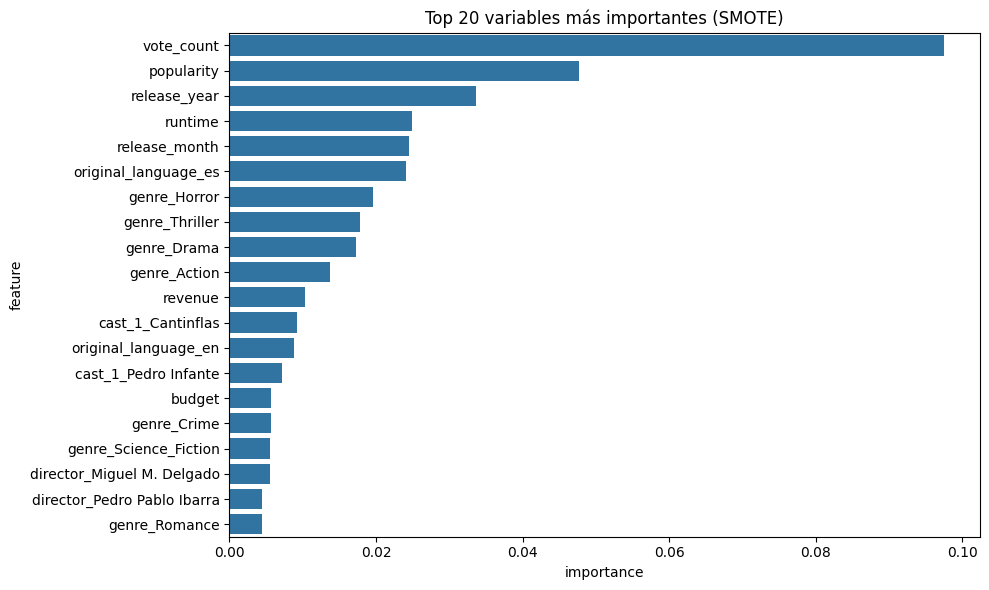

In [91]:
# Extraer importancia
importancia_smote = clf.feature_importances_

# Visualizar top 20
df_importancia_smote = pd.DataFrame({
    'feature': X.columns,
    'importance': importancia_smote
}).sort_values(by='importance', ascending=False).head(20)

plt.figure(figsize=(10,6))
sns.barplot(x='importance', y='feature', data=df_importancia_smote)
plt.title('Top 20 variables más importantes (SMOTE)')
plt.tight_layout()
plt.show()

In [74]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='f1')
grid_search.fit(X_resampled, y_resampled)

print("Best params:", grid_search.best_params_)


Best params: {'max_depth': None, 'min_samples_split': 5, 'n_estimators': 200}
